In [1]:
!python /Users/kit/Documents/Phys_Working/LLM_SR/check_path.py

import sys
print("\nAdding project directory to Python path...")
sys.path.insert(0, '/Users/kit/Documents/Phys_Working/LLM_SR')
print(f"  - Added: {sys.path[0]}")

import LLMSR
import openai

import os
import numpy as np
import matplotlib.pyplot as plt

Python executable: /Users/kit/Documents/Phys_Working/LLM_SR/.venv/bin/python
Python version: 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:51:49) [Clang 16.0.6 ]

System Path:
  - /Users/kit/Documents/Phys_Working/LLM_SR
  - /opt/homebrew/Caskroom/miniforge/base/lib/python310.zip
  - /opt/homebrew/Caskroom/miniforge/base/lib/python3.10
  - /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload
  - /Users/kit/Documents/Phys_Working/LLM_SR/.venv/lib/python3.10/site-packages

Site Packages:
  - /Users/kit/Documents/Phys_Working/LLM_SR/.venv/lib/python3.10/site-packages

LLMSR is installed at: /Users/kit/Documents/Phys_Working/LLM_SR/LLMSR

Adding project directory to Python path...
  - Added: /Users/kit/Documents/Phys_Working/LLM_SR


In [2]:

api_key = os.getenv("OPENROUTER_API_KEY") if os.getenv("OPENROUTER_API_KEY") else "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"
client = openai.OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=api_key,
)

2025-03-10 21:14:20,243 - LLMSR.images - INFO - Encoding image from path: plot.png
2025-03-10 21:14:20,244 - LLMSR.images - INFO - Successfully encoded image: 22200 characters


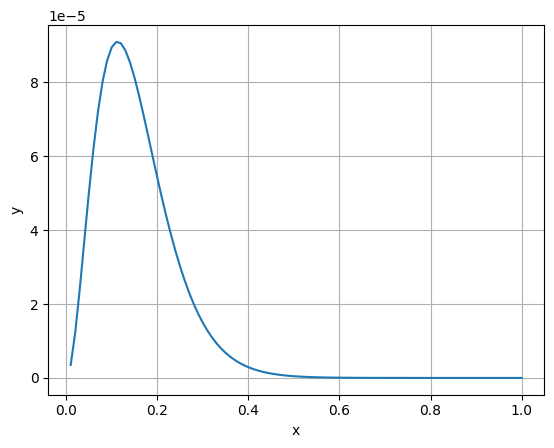

In [3]:
x = np.linspace(0.01, 1, 100)
y = x**3./(np.exp(25*x)-1)
#y = np.pi*np.ones(100)

plt.plot(x, y,label='data')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
#plt.legend()
plt.savefig('plot.png')

# Getting the Base64 string
base64_image = LLMSR.images.encode_image('plot.png')

In [4]:
r = LLMSR.single_call(client, base64_image, x, y, model="openai/gpt-4o",function_list=None, system_prompt=None)
print(r)

2025-03-10 21:14:22,440 - LLMSR.llmSR - INFO - Starting single_call with model=openai/gpt-4o, function_list size=0
2025-03-10 21:14:24,794 - LLMSR.llmSR - INFO - Extracted ansatz: params[0] * np.exp(-params[1] * x) with 2 parameters
2025-03-10 21:14:24,795 - LLMSR.fit - INFO - Fitting curve with 2 parameters
2025-03-10 21:14:24,796 - LLMSR.fit - INFO - Optimized parameters: [7.83369649e-05 3.96642390e+00]
2025-03-10 21:14:24,796 - LLMSR.fit - INFO - Fit complete: chi-squared=0.00031694801001521186
2025-03-10 21:14:24,797 - LLMSR.llmSR - INFO - Fit result: score=-0.00031694801001521186, params=[7.83369649e-05 3.96642390e+00]


{'params': array([7.83369649e-05, 3.96642390e+00]), 'score': np.float64(-0.00031694801001521186), 'ansatz': 'params[0] * np.exp(-params[1] * x)', 'Num_params': 2, 'response': ChatCompletion(id='gen-1741641262-s98452pFz92cRM18f2rp', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='```python\ncurve_1 = lambda x, *params: params[0] * np.exp(-params[1] * x)\n```', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None), native_finish_reason='stop')], created=1741641262, model='openai/gpt-4o', object='chat.completion', service_tier=None, system_fingerprint='fp_fc9f1d7035', usage=CompletionUsage(completion_tokens=30, prompt_tokens=505, total_tokens=535, completion_tokens_details=None, prompt_tokens_details=None), provider='OpenAI'), 'prompt': 'import numpy as np \ncurve_0 = lambda x,*params: params[0] \ncurve_1 = lambda x,*params:', 'function_list': None}


pop_size = 10 and num_of_generations = 5 will cost about $0.10 on 4o-mini

In [5]:
population_size = 10
num_of_generations = 5
start = LLMSR.llm.check_key_limit(client)
res = LLMSR.run_genetic(client, base64_image, x, y, population_size,num_of_generations, 
                        temperature=1., model="openai/gpt-4o", system_prompt=None, elite=False, use_async=True)
print(f"Credits spent: {start - LLMSR.llm.check_key_limit(client)}")

2025-03-10 21:14:31,549 - LLMSR.llm - INFO - API key check successful. Remaining limit: None
2025-03-10 21:14:31,550 - LLMSR.llmSR - INFO - Starting genetic algorithm with population_size=10, generations=5, model=openai/gpt-4o
2025-03-10 21:14:31,551 - LLMSR.llmSR - INFO - Checking constant function as baseline
2025-03-10 21:14:31,552 - LLMSR.llmSR - INFO - Constant function baseline: score=-0.0007843612910038471, constant=1.6624442549758262e-05
2025-03-10 21:14:31,553 - LLMSR.llmSR - INFO - Generating initial population
2025-03-10 21:14:31,553 - LLMSR.llmSR - INFO - Using async mode for population generation
2025-03-10 21:14:31,554 - LLMSR.llmSR - INFO - Starting async_single_call with model=openai/gpt-4o, function_list size=0
2025-03-10 21:14:31,560 - LLMSR.llmSR - INFO - Starting async_single_call with model=openai/gpt-4o, function_list size=0
2025-03-10 21:14:31,566 - LLMSR.llmSR - INFO - Starting async_single_call with model=openai/gpt-4o, function_list size=0
2025-03-10 21:14:31,

Constant function is not a good fit.
Score:  -0.0007843612910038471
Constant:  [1.66244425e-05]
Generating Initial population population


2025-03-10 21:14:33,519 - LLMSR.fit - INFO - Fitting curve with 2 parameters
2025-03-10 21:14:33,522 - LLMSR.fit - INFO - Optimized parameters: [7.83369649e-05 3.96642390e+00]
2025-03-10 21:14:33,522 - LLMSR.fit - INFO - Fit complete: chi-squared=0.00031694801001521186
2025-03-10 21:14:33,550 - LLMSR.fit - INFO - Fitting curve with 3 parameters
2025-03-10 21:14:33,553 - LLMSR.fit - INFO - Optimized parameters: [2.35680767e-04 7.24592665e+00 7.83428831e+00]
2025-03-10 21:14:33,554 - LLMSR.fit - INFO - Fit complete: chi-squared=2.8008318919780447e-05
2025-03-10 21:14:33,583 - LLMSR.fit - INFO - Fitting curve with 2 parameters
2025-03-10 21:14:33,585 - LLMSR.fit - INFO - Optimized parameters: [7.83369649e-05 3.96642390e+00]
2025-03-10 21:14:33,586 - LLMSR.fit - INFO - Fit complete: chi-squared=0.00031694801001521186
2025-03-10 21:14:33,923 - LLMSR.fit - INFO - Fitting curve with 3 parameters
2025-03-10 21:14:33,930 - LLMSR.fit - INFO - Error during curve fitting, getting another response:

Best score:  -3.0111945182542027e-07
Best ansatz:  params[0] * x**params[1] * np.exp(-params[2] * x)
Best params:  [ 0.24513435  2.46531172 22.29670414]
Exit condition met.


2025-03-10 21:14:41,260 - LLMSR.llm - INFO - API key check successful. Remaining limit: None


TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [6]:
len(res[0])

10

In [6]:
highest_score_element = max((item for sublist in res for item in sublist), key=lambda item: item['score'])
print(highest_score_element['ansatz'])

params[0] * x**params[1] * np.exp(-params[2] * x)


In [7]:
print(highest_score_element['function_list'])

None


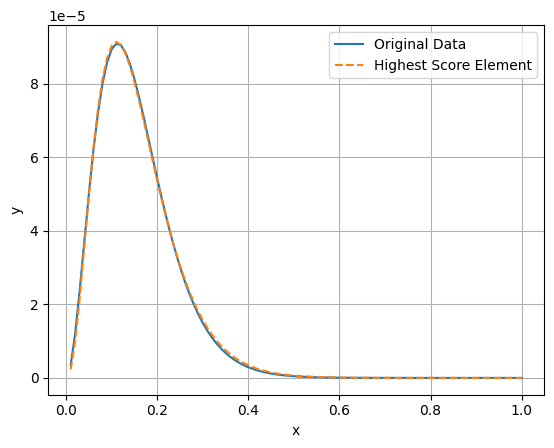

In [8]:
# Extract the parameters and the ansatz function from the highest_score_element
params = highest_score_element['params']
ansatz = highest_score_element['ansatz']

# Define the ansatz function
def ansatz_function(x, params):
    return eval(ansatz)

# Plot the original data
plt.plot(x, y, label='Original Data')

# Plot the highest score element
plt.plot(x, ansatz_function(x, params), label='Highest Score Element', linestyle='--')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

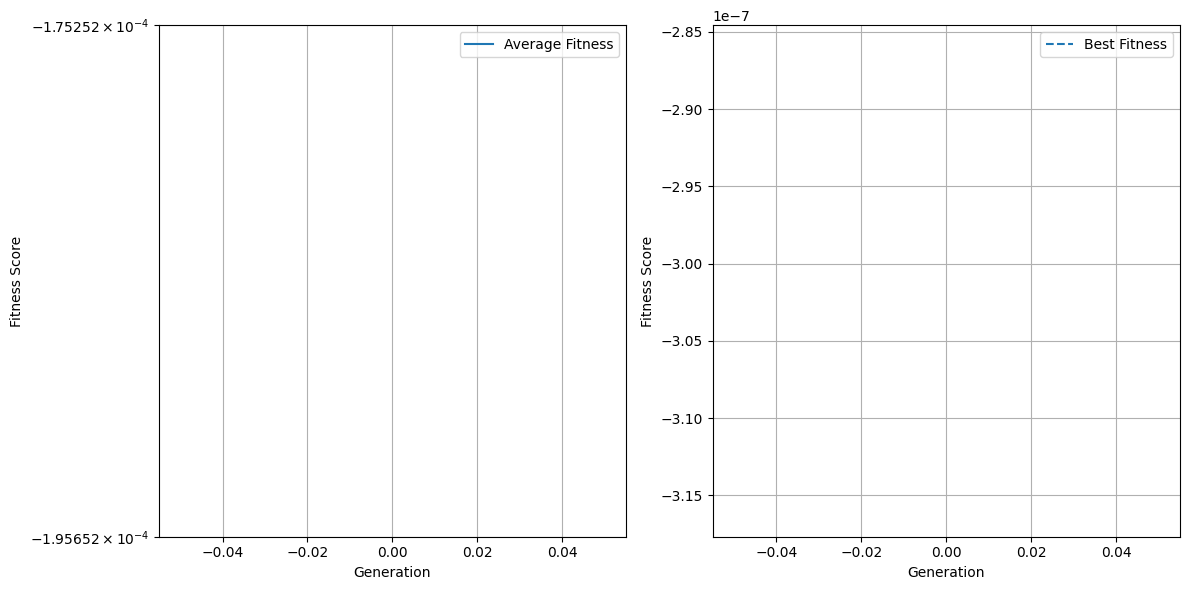

In [9]:
# Remove infinite scores
filtered_res = [[ind for ind in generation if np.isfinite(ind['score'])] for generation in res]

# Extract fitness scores from the filtered results
average_fitness = [np.mean([ind['score'] for ind in generation]) for generation in filtered_res]
best_fitness = [max([ind['score'] for ind in generation]) for generation in filtered_res]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the average fitness
axs[0].plot(range(len(average_fitness)), average_fitness, label='Average Fitness')
axs[0].set_xlabel('Generation')
axs[0].set_ylabel('Fitness Score')
axs[0].set_yscale('symlog')
axs[0].legend()
axs[0].grid(True)

# Plot the best fitness
axs[1].plot(range(len(average_fitness)), best_fitness, label='Best Fitness', linestyle='--')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Fitness Score')
axs[1].legend()
axs[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()

In [14]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Copy the function to test (simplified version for testing)
def fit_curve_with_guess(x, y, curve, params_initial, try_all_methods=False, log_everything=False):
    if len(x.squeeze().shape) > 1:
        dimension_of_x = x.shape[1]
        print(f"Dimension of x: {dimension_of_x}")
        
        def curve_fit_wrapper(curve, x, y, p0=None, **kwargs):
            print(x.shape, y.shape)
            xtranspose = np.transpose(x)
            
            def wrapped_curve(X, *params):
                # This is corrected from the original to actually use the input data
                return curve(*[X[i] for i in range(dimension_of_x)], *params)
            
            return curve_fit(wrapped_curve, xtranspose, y, p0=p0, **kwargs)
        
        curve_fit_here = curve_fit_wrapper
    else:
        curve_fit_here = curve_fit
    
    try:
        print(f"Fitting curve with initial parameters: {params_initial}")
        params_opt, _ = curve_fit_here(curve, x, y, p0=params_initial)
        print(f"Fitted parameters: {params_opt}")
        
        # Calculate chi-squared
        if len(x.squeeze().shape) > 1:
            residuals = y - curve(*[x[:, i] for i in range(x.shape[1])], *params_opt)
            curvevals = curve(*[x[:, i] for i in range(x.shape[1])], *params_opt)
        else:
            residuals = y - curve(x, *params_opt)
            curvevals = curve(x, *params_opt)
        
        chi_squared = np.mean((residuals ** 2) / (np.square(curvevals) + 1e-6))
        return params_opt, chi_squared
    
    except Exception as e:
        print(f"Curve fitting failed: {str(e)}")
        return np.array(params_initial), np.inf

# Define a simple test curve
def test_curve(x1, x2, a, b, c):
    return a * x1**2 + b * x2 + c

test_curve = lambda x1, x2, a, b, c: a * x1**2 + b * x2 + c

# Test the function
def test_function():
    # Generate synthetic data
    np.random.seed(42)
    x1 = np.linspace(-5, 5, 20)
    x2 = np.linspace(-5, 5, 20)
    X1, X2 = np.meshgrid(x1, x2)
    
    # Flatten for easier handling
    x1_flat = X1.flatten()
    x2_flat = X2.flatten()
    
    # True parameters
    true_params = [2.5, 1.8, 3.0]  # a, b, c
    
    # Generate y values with some noise
    y_true = test_curve(x1_flat, x2_flat, *true_params)
    noise = np.random.normal(0, 0.5, size=y_true.shape)
    y_noisy = y_true + noise
    
    # Combine x values
    x_combined = np.column_stack((x1_flat, x2_flat))
    
    # Initial guess
    initial_guess = [1.0, 1.0, 1.0]
    
    # Call the function
    fitted_params, chi_squared = fit_curve_with_guess(x_combined, y_noisy, test_curve, initial_guess)
    
    # Print results
    print("\nResults:")
    print("True parameters:", true_params)
    print("Fitted parameters:", fitted_params)
    print("Chi-squared:", chi_squared)

if __name__ == "__main__":
    test_function()

Dimension of x: 2
Fitting curve with initial parameters: [1.0, 1.0, 1.0]
(400, 2) (400,)
Fitted parameters: [2.49781925 1.811266   3.03136012]

Results:
True parameters: [2.5, 1.8, 3.0]
Fitted parameters: [2.49781925 1.811266   3.03136012]
Chi-squared: 0.13125593852093287
